## Setup

In [30]:
import numpy as np
np.random.seed(16)

import sklearn
from sklearn import datasets

## Projected

In [31]:
from optilibrary import project

In [32]:
from optilibrary import ProjGD_Ball
help(ProjGD_Ball)

Help on function ProjGD_Ball in module optilibrary:

ProjGD_Ball(th0, F, gradF, step, max_iter, projectionfunction, tol, R=1)
    Function implementing projected gradient descent (PGD) onto the simplex, l1-ball or l2-ball
    
    Inputs:
        th0: initial point
        F: objective function
        gradF: function computing gradient of the objective
        step: step-size parameter
        max_iter: maximum number of iteration before stopping
        projectionfunction: function computing chosen projection
        tol: tolerance for objective; stopping condition
        R (optional): radius/sum of ball with default set to 1
    
    Outputs:
        iters: array of iterates generated for theta
        errs: array of successive mean-squared errors.



A general equation of a paraboloid is stated with three terms:
$$P(x) = x^{T}Ax + Cx + d $$ 
for $A \in \mathbb{R}^{n\times{n}} \succ{0}$, $C\in\mathbb{R}^{n}$, and $d\in\mathbb{R}$

#### Generating data

In [33]:
dim = 2
#Generate problem
A = datasets.make_spd_matrix(dim, random_state=16)
A = A

B = np.random.uniform(0, 1, dim)
B = B/np.sum(B)

d = np.random.uniform(-1, 0,1)

#goal: recover x given some observed y - values
P = lambda x: x.T.dot(x.T.dot(A)) + B.dot(x) + d
gradP = lambda x: A.dot(x) + B

#### Determine 
$$ \min_{x} P(x) \text{    s.t.   } ||{x}||\leq{R} $$

where projection $$\Pi_{A}(x) = \frac{R}{max(||x||_2, R)}x$$ 

Choose an arbitrary starting point $x_0$ on the boundary of the $\ell_2$-ball with radius $R$

In [48]:
R = 1.25
x0 = np.random.randn(dim)
maxiter = 200

The gradient writes as 
$$\nabla{P} = Ax + C$$


Run an iteration of PGD for the $\ell_2$-ball:

In [49]:
iters = []
errs = []
lball = [1, 2]
tol=1e-20

for l in lball:
    proj_rule = lambda x, R: project(l, x, R)
    x = project(l, x0, R)
    it, e = ProjGD_Ball(x, P, gradP, tol=tol, step=0.1, max_iter=maxiter, R=R, projectionfunction=proj_rule)
    iters.append(it)
    errs.append(e)
# errs = np.array(errs)

#### Consider the errors

C:\Users\norti\AppData\Local\Temp\ipykernel_25064\3816336322.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(i[1:]))


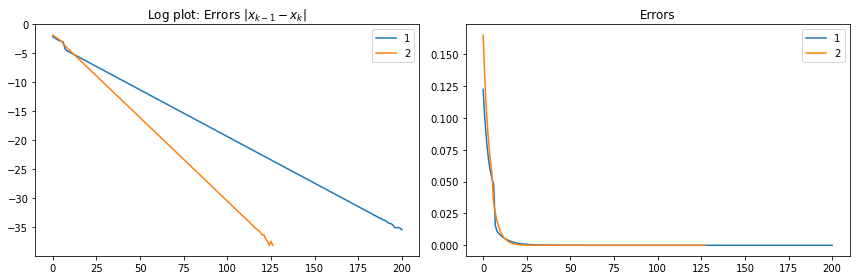

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
for i in errs:
    plt.plot(np.log(i[1:]))
plt.legend(lball)
# plt.plot(np.log(errs))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
for i in errs:
    plt.plot(i[1:])
plt.legend(lball)
plt.title('Errors');


In [51]:
from scipy.optimize import minimize
res = minimize(P, x0, method='nelder-mead', options={'xatol':1e-8}) 
res.x

array([-0.17323659, -1.2442938 ])

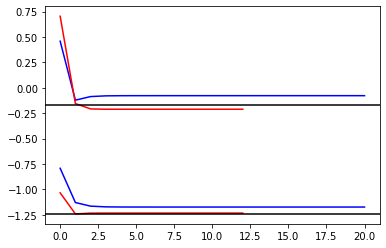

In [52]:
l1iters = iters[0]
l2iters = iters[1]

# l1iters[:,::10]
plt.plot(l1iters[:,::10].T, color='b');
plt.plot(l2iters[:,::10].T, color='r');
plt.axhline(res.x[0], color='k')
plt.axhline(res.x[1], color='k')

#### Plot
And plot the results

In [53]:
n = 50
t = np.linspace(-3, 3, n)
X, Y = np.meshgrid(t,t)

In [54]:
vals = np.zeros(iters[1].shape[1])
for i in range(iters[1].shape[1]):
    vals[i] = P(iters[1][:,i])

temp = np.zeros(n*n)
Z = np.vstack((X.ravel(), Y.ravel()))
for i in range(Z.shape[1]):
    temp[i] = (P(Z[0:2, i]))
    
temp = temp.reshape((n,n))

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [56]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = R*(np.cos(u) * np.sin(v))
y = R*(np.sin(u) * np.sin(v))-1
z = np.cos(v)*R

In [57]:
%matplotlib qt
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.scatter3D(iters[1][0,0], iters[1][1,0], vals[0], s=5, c='r', label='starting point')
ax.scatter3D(iters[1][0,1:], iters[1][1,1:], vals[1:], c='b', s=5, label='iterations of projected Gradient')
ax.plot_surface(X, Y, temp, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.1)
ax.plot_wireframe(x, y, z, alpha=0.3, color='k')

#d=3
# ax.scatter3D(iters[1][0,0], iters[1][1,0], iters[1][2,0], s=5, c='r', label='starting point') #starting point
# ax.scatter3D(iters[1][0,1:], iters[1][1,1:], iters[1][2,1:], c='b', s=5, label='iterations of projected Gradient')

ax.set_xlim(-R-R/10,R+R/10)
ax.set_ylim(-R-R/10,R+R/10)
ax.set_zlim(-R-R/10,R+R/10)
# ax.axis('off');
ax.legend();

## Franke-Wolfe / Conditional gradient

For conditional gradient on the $\ell_2$-ball with radius $R$, we solve for 

\begin{equation}\tag{1}
s_{k+1} \in \underset{s \in B(0,R)}{\mathrm{argmin}} \big\{ f(x_k) + \langle\ \nabla f(x_k), s - x_k \rangle\ \big\}
\end{equation}

to obtain: 
\begin{equation}\tag{2}
s_{k+1,j} = - R \frac{sign(\nabla f_j(x_k))|\nabla f_j(x_k)|}{||\nabla f(x_k)||_2}
\end{equation}

In [13]:
from optilibrary import argmin, extrpt
# help(argmin)
# help(extrpt)

The weighting of the convex combination may be determined by exact linesearch:
\begin{equation}\tag{3}
\theta_k \in \argmin_{\theta\in{[0,1]}} f(\theta_k s_{k+1} + (1-\theta) x_k)
\end{equation}

or by making use of a prescribed step size such as 
\begin{equation}\tag{4}
\theta_k = \frac{2}{k+2}
\end{equation}

In [14]:
from optilibrary import updatetheta, CondGD
# help(updatetheta)
# help(CondGD)

In [15]:
def rules(lball):
    theta_rule = lambda k, sk: updatetheta('fixed', k, sk, f=P, gradf=gradP)
    extr_rule = lambda d, R: extrpt(d, R, lball)
    argm_rule = lambda x, R: argmin(x, R, lball)
    proj_rule = lambda x, R: project(lball, x, R)

    return theta_rule, extr_rule, argm_rule, proj_rule

theta_rule, extr_rule, argm_rule, proj_rule = rules(lball=1)

maxit=100
R=0.75
step = 0.1
tol = 1e-20

iter_cond, err_cond = CondGD(f=P, gradf=gradP, R=R, pick_theta_rule=theta_rule, extr_pt_rule=extr_rule, argminrule=argm_rule, dim=dim, maxit=maxit)
iter_proj, err_proj = ProjGD_Ball(x0, P, gradP, tol=tol, step=step, max_iter=maxit, R=R, projectionfunction=proj_rule)

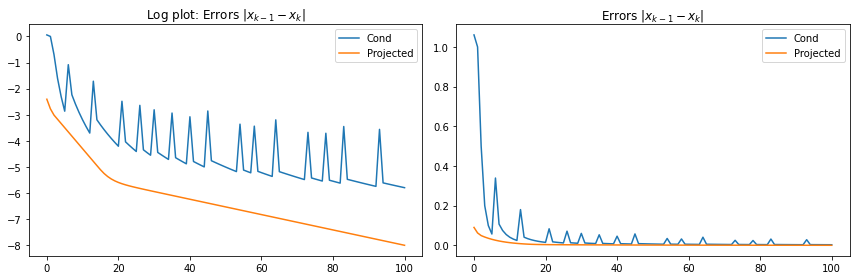

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(err_cond[1:]))
plt.plot(np.log(err_proj[1:]))
plt.legend(('Cond', 'Projected'))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(err_cond[1:])
plt.plot(err_proj[1:])
plt.legend(('Cond', 'Projected'))
plt.title(r'Errors $|x_{k-1}-x_{k}|$');

In [17]:
print("Final Error: ", err_cond[-1], err_proj[-1])

Final Error:  0.0030530847448565065 0.00033613099134270375


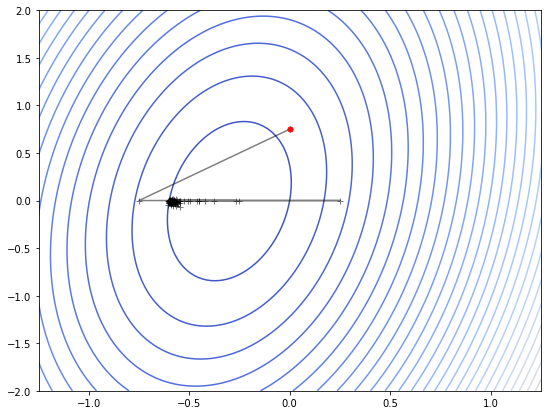

In [18]:
t = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(t, t)
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 50, cmap='coolwarm');
plt.plot(iter_cond[:,0], iter_cond[:, 1], marker = '+', color = 'k', alpha=0.5)
plt.plot(iter_cond[0,0], iter_cond[0,1], marker='.', markersize=10, color='r')
plt.xlim(np.min(iter_cond[:,0])-0.5, np.max(iter_cond[:,1])+0.5);